In [15]:
import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

my_transform = transforms.Compose([
    transforms.Resize((375, 500)),
    transforms.ToTensor()
])

def mask_transform(mask):
  mask = mask.resize((500, 375), resample=Image.NEAREST)
  mask_np = np.array(mask)
  mask_tensor = torch.as_tensor(mask_np, dtype=torch.long)
  return mask_tensor


dataset = VOCSegmentation(root='./data',
                          year='2012',
                          image_set='train',
                          download=True,
                          transform=my_transform, # Added comma here
                          target_transform=mask_transform)

image, mask = dataset[3]
image, mask
image.shape, mask.shape

(torch.Size([3, 375, 500]), torch.Size([375, 500]))

In [16]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [17]:
import torchvision.models.segmentation as models
import torch

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model = models.deeplabv3_resnet50(pretrained=False, num_classes=21).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [25]:
epochs = 5
model.train()

for epoch in range(epochs):
  total_loss = 0
  for image, mask in train_loader:
    image, mask = image.to(device), mask.to(device)

    # Remove the channel dimension and ensure mask is of type long
    #mask = mask.squeeze(1).long()

    output = model(image)["out"]
    loss = loss_fn(output, mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.1193
Epoch 2/5, Loss: 0.0994
Epoch 3/5, Loss: 0.1183
Epoch 4/5, Loss: 0.1368
Epoch 5/5, Loss: 0.0796


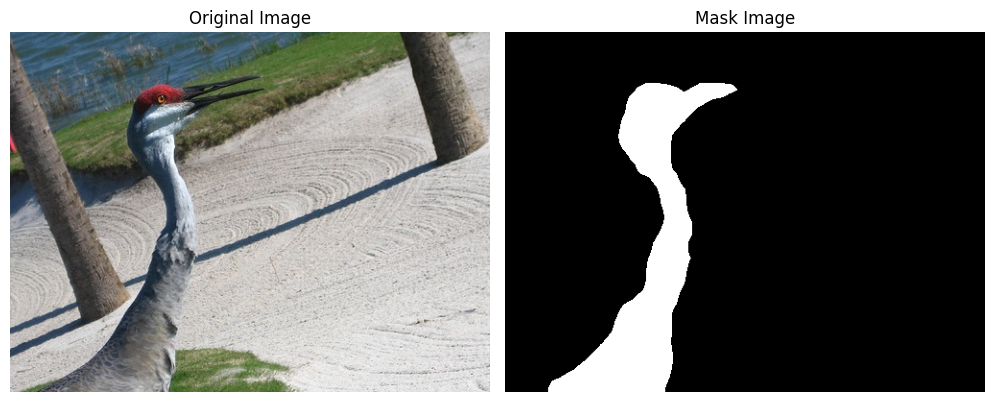

In [39]:
model.eval()
image, mask = dataset[3]
image, mask = image.to(device), mask.to(device)
image = image.unsqueeze(0) # Add a batch dimension
with torch.no_grad():  # spart Speicher
    output = model(image)["out"]
output, mask

#hier mit matplotlib alles zecihenen lassen
image = image.squeeze(0)  # → [3, H, W]
image = image.cpu().permute(1, 2, 0).numpy()
output = output.argmax(1).squeeze(0)
output = output.cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(output, cmap='gray')
plt.title("Mask Image")
plt.axis("off")

plt.tight_layout()
plt.show()

In [36]:
torch.save(model.state_dict(), "modelResnet.pth")